This notebook demonstrates an experiment.
As an example, Field-weighted Factorization Machine: https://arxiv.org/abs/1806.03514 is used.

In [20]:
import datetime
import os
import pickle
from pathlib import Path

import itertools
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tqdm import tqdm
from pandas import DataFrame
from tensorflow import keras

from src.config import TrainConfig
from src.data.data_generator import DataGenerator
from src.data.msmarco import preprocessors
from src.losses import pairwise_losses
from src.utils.seed import set_seed
from src.utils.plot import plot_history
from src.metrics import metrics
from src.models.base_model import BaseModel
from src.layers.bias import AddBias0
from src.losses import pairwise_losses

import matplotlib.pyplot as plt
import seaborn as sns

project_dir = '../'

In [21]:
from src.data.msmarco.docs import load_raw_docs

docs = load_raw_docs()
data_processor = preprocessors.ConcatDataProcessor(docs)

In [22]:
def get_field_weights(model):
    weight_names = [weight.name for layer in model.layers for weight in layer.weights]
    w = None
    for name, weight in zip(weight_names, model.get_weights()):
        if 'field_weights' in name:
            w = weight
    for i in range(4):
        w[i][i] = None
    for i, j in itertools.combinations(range(4), 2):
        w[j][i] = w[i][j]
    return w

def show_field_weights(model):
    w = get_field_weights(model)
    label = ['query', 'url', 'title', 'body']
    sns.heatmap(w, xticklabels=label, yticklabels=label, annot=True)
    plt.show()

In [23]:
class WeightedFeatureInteraction(tf.keras.layers.Layer):
    def __init__(self, num_fields, **kwargs):
        self.num_fields = num_fields
        super(WeightedFeatureInteraction, self).__init__(**kwargs)

    def build(self, input_shape):
        w_init = tf.constant_initializer(value=0)
        self.field_weights = tf.Variable(
            initial_value=w_init(shape=(self.num_fields, self.num_fields), dtype=tf.float32),
            name='field_weights',
        )
        self.dot = layers.Dot(axes=1, normalize=True)
        super(WeightedFeatureInteraction, self).build(input_shape)

    def call(self, inputs):
        dim = inputs.shape[1] // self.num_fields
        interactions = []
        for i, j in itertools.combinations(range(self.num_fields), 2):
            feature1, feature2 = inputs[:, i*dim:(i+1)*dim], inputs[:, j*dim:(j+1)*dim]
            interaction = self.dot([feature1, feature2])
            interaction = tf.math.scalar_mul(self.field_weights[i, j], interaction)
            interactions.append(interaction)
        return layers.concatenate(interactions)
    
    def compute_output_shape(self, input_shape):
        return None, self.num_fields

    def get_config(self):
        config = super(WeightedFeatureInteraction, self).get_config().copy()
        config.update({
            'num_fields': self.num_fields,
        })
        return config
    
class FwFMAll(BaseModel):
    @property
    def name(self) -> str:
        return 'fwfm_all'

    def build(self):
        text_inputs = [
            self.new_query_input(size=20),
            self.new_url_input(),
            self.new_title_input(),
            self.new_body_input(),
        ]
        inputs = text_inputs

        word_embedding = layers.Embedding(self.total_words, self.embedding_dim, name='text_embedding')
        text_features = [word_embedding(text_input) for text_input in text_inputs]
        text_features = [layers.GlobalMaxPooling1D()(feature) for feature in text_features]
        input_features = text_features

        interactions = []
        num_fields = len(input_features)
        features = tf.concat(input_features, axis=1)
        weighted_interaction = WeightedFeatureInteraction(num_fields)
        interactions = weighted_interaction(features)
        
        features = []
        for feature in input_features:
            feature = layers.Dense(1, activation='relu')(feature)
            features.append(feature)
        features = tf.concat(features, axis=1)
        
        x = tf.concat([features, interactions], axis=1)
        visualizer = tf.keras.Model(inputs=inputs, outputs=x)
        x = tf.keras.backend.sum(x, axis=1, keepdims=True)
        output = layers.Activation('sigmoid', name='label')(x)
        return tf.keras.Model(inputs=inputs, outputs=output, name=self.name), visualizer

In [26]:
config = TrainConfig(
    dataset=f'listwise.msmarco.0',
    data_processor=data_processor,
    data_processor_filename=f'concat_data_processor.msmarco',
    model=FwFMAll,
    epochs=6,
)

In [27]:
data_processor = config.data_processor
train_df = data_processor.listwise_to_pairs(f'{config.dataset}.train.pkl')
val_df = data_processor.listwise_to_pairs(f'{config.dataset}.val.pkl')
data_processor.fit(train_df)

train_generator = DataGenerator(train_df, data_processor)
val_generator = DataGenerator(val_df, data_processor)

100%|██████████| 36702/36702 [00:00<00:00, 209555.62it/s]


Model: "fwfm_all"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
query (InputLayer)              [(None, 20)]         0                                            
__________________________________________________________________________________________________
url (InputLayer)                [(None, 20)]         0                                            
__________________________________________________________________________________________________
title (InputLayer)              [(None, 20)]         0                                            
__________________________________________________________________________________________________
body (InputLayer)               [(None, 12000)]      0                                            
___________________________________________________________________________________________

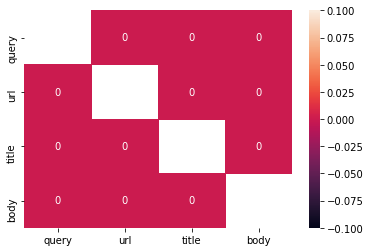

In [28]:
model, visualizer = config.model(data_processor).build()
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss={'label': pairwise_losses.cross_entropy_loss},
    metrics=['accuracy']
)
model.summary()
show_field_weights(model)

In [29]:
history = model.fit(
    train_generator,
    epochs=config.epochs,
    validation_data=val_generator,
)

Epoch 1/6


/Users/kentaro-takiguchi/workspace/master-thesis/.venv/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['doc_id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


964/964 [==============================] - 1867s 2s/step - loss: 0.6546 - accuracy: 0.6143 - val_loss: 0.6239 - val_accuracy: 0.6531
Epoch 2/6
964/964 [==============================] - 1840s 2s/step - loss: 0.5816 - accuracy: 0.7098 - val_loss: 0.6032 - val_accuracy: 0.6655
Epoch 3/6
964/964 [==============================] - 1978s 2s/step - loss: 0.5201 - accuracy: 0.7907 - val_loss: 0.5994 - val_accuracy: 0.6596
Epoch 4/6
964/964 [==============================] - 2009s 2s/step - loss: 0.4635 - accuracy: 0.8629 - val_loss: 0.6039 - val_accuracy: 0.6443
Epoch 5/6
964/964 [==============================] - 1919s 2s/step - loss: 0.4198 - accuracy: 0.9124 - val_loss: 0.6071 - val_accuracy: 0.6304
Epoch 6/6
964/964 [==============================] - 1868s 2s/step - loss: 0.3900 - accuracy: 0.9407 - val_loss: 0.6098 - val_accuracy: 0.6227


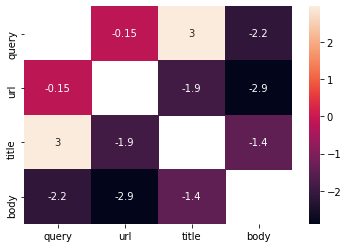

In [30]:
show_field_weights(model)

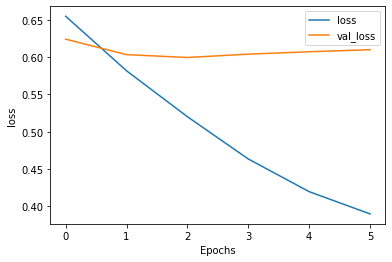

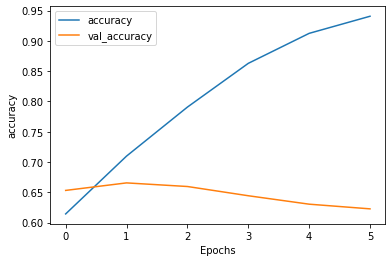

In [31]:
plot_history(history, 'loss')
plot_history(history, 'accuracy')

/Users/kentaro-takiguchi/workspace/master-thesis/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/kentaro-takiguchi/workspace/master-thesis/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(0.6227, 0.7114, 0.4128)

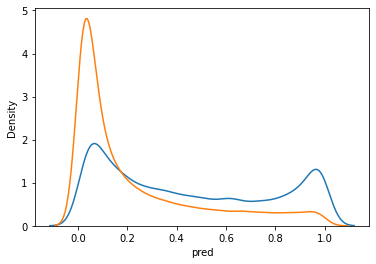

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

val_df['pred'] = model.predict(val_generator)

temp = val_df[val_df['label'] == 1]
sns.distplot(temp['pred'], hist=False, label='label: 1')
temp = val_df[val_df['label'] == 0]
sns.distplot(temp['pred'], hist=False, label='label: 0')

y_true = val_df['label']
y_pred = val_df['pred']
round(accuracy_score(y_true, y_pred > 0.5), 4), round(precision_score(y_true, y_pred > 0.5), 4), round(recall_score(y_true, y_pred > 0.5), 4)

In [33]:
def evaluate(model, dataset, data_processor, verbose=1) -> float:
    ndcg_scores = []
    for example in (tqdm(dataset) if verbose > 0 else dataset):
        rows = []
        for doc in example['docs']:
            row = {
                'query': example['query'],
                'doc_id': doc['doc_id'],
                'label': doc['label']
            }
            rows.append(row)
        df = DataFrame(rows)
        x, y = data_processor.process_batch(df)
        dataset = tf.data.Dataset.from_tensor_slices((x, {'label': y})).batch(128)
        preds = model.predict(dataset, verbose=0)
        df['pred'] = preds
        y_true = df['label'].tolist()
        y_pred = df['pred'].tolist()
        ndcg_scores.append(metrics.normalized_discount_cumulative_gain(y_true, y_pred))

    ndcg_score = round(np.mean(ndcg_scores), 4)
    return ndcg_score

with open(f'{project_dir}/data/processed/listwise.msmarco.val.pkl', 'rb') as file:
    val_dataset = pickle.load(file)

ndcg_score = evaluate(model, val_dataset, data_processor)
f'NDCG: {ndcg_score}'

  0%|          | 0/1039 [00:00<?, ?it/s]/Users/kentaro-takiguchi/workspace/master-thesis/.venv/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['doc_id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
100%|██████████| 1039/1039 [10:05<00:00,  1.72it/s]


'NDCG: 0.1509'

In [34]:
features = [
    'query', 'url', 'title', 'body',
    'query-url', 'query-title', 'query-body',
    'url-title', 'url-body',
    'title-body',
]

In [35]:
output = visualizer.predict(val_generator)
output_with_label = np.concatenate([output, val_df['label'].to_numpy().reshape((-1,1))], axis=1)
columns = features + ['label']
output_df = DataFrame(output_with_label, columns=columns)
positive_output_df = output_df[output_df['label'] == 1]
negative_output_df = output_df[output_df['label'] == 0]

<AxesSubplot:xlabel='corr', ylabel='feature'>

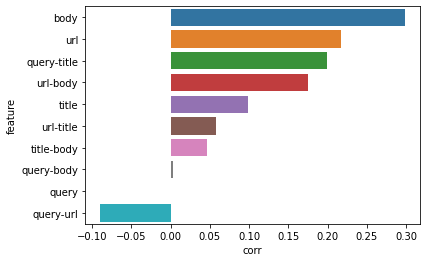

In [36]:
corr_df = output_df.corr()
corr_df = corr_df[['label']].sort_values(by='label', ascending=False).reset_index()
corr_df = corr_df.rename(columns={'index': 'feature', 'label': 'corr'})
corr_df = corr_df[~(corr_df['feature'] == 'label')]
plt.figure(figsize=(6,4))
sns.barplot(data=corr_df, x='corr', y='feature')

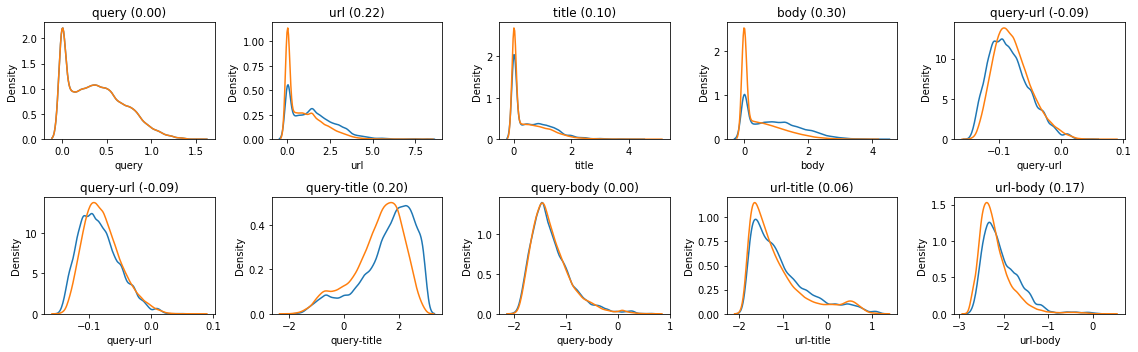

In [43]:
def plot_dist(feature, ax):
    sns.kdeplot(positive_output_df[feature], label='label: 1', ax=ax)
    sns.kdeplot(negative_output_df[feature], label='label: 0', ax=ax)
    
def significance(feature):
    return corr_df[corr_df['feature'] == feature]['corr'].iloc[0]

fig, axes = plt.subplots(2, 5, figsize=(16,5))
for i in range(2):
    for j in range(5):
        idx = i * 4 + j
        if idx < len(features):
            feature = features[idx]
            plot_dist(feature, axes[i][j])
            sig = significance(feature)
            axes[i][j].set_title(f'{feature} ({sig:.2f})')
        else:
            axes[i][j].set_axis_off()
fig.tight_layout()

In [38]:
from IPython.core.display import HTML

def explain(idx, query=None, attrs=None):
    sample = val_df.iloc[idx].copy()
    doc = docs[sample['doc_id']].copy()
    if query:
        sample['query'] = query
    if attrs:
        sample['doc_id'] = -1
        doc['doc_id'] = -1
        doc['url'] = attrs['url']
        doc['title'] = attrs['title']
        doc['body'] = attrs['body']
        data_processor.docs[-1] = doc
    samples_df = sample.to_frame().T
    display(samples_df)
    display(HTML(f"<b>query</b>: {sample['query']}"))
    display(HTML(f"<b>url</b>: {doc['url']}"))
    display(HTML(f"<b>title</b>: {doc['title']}"))
    display(HTML(f"<b>body</b>: {doc['body'][:300]}..."))
    data = data_processor.process_batch(samples_df)
    dataset = tf.data.Dataset.from_tensor_slices((data))
    generator = dataset.cache().batch(1)
    pred = model.predict(generator)[0][0]
    display(HTML(f"<b>pred</b>: {pred:.2f}"))
    output = visualizer.predict(generator)[0]
    rows = []
    for i in range(len(features)):
        rows.append({
            'feature': features[i],
            'value': output[i],
        })
    temp = DataFrame(rows).sort_values(by=['value'], ascending=False)
    plt.figure(figsize=(6,4))
    sns.barplot(data=temp, x='value', y='feature')
    plt.show()

,query,doc_id,label,pred
15896,how many ounces are amateur boxing gloves,646748,1,0.14842


/Users/kentaro-takiguchi/workspace/master-thesis/.venv/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['doc_id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


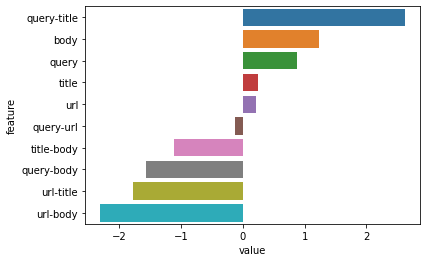

,query,doc_id,label,pred
15899,how many ounces are amateur boxing gloves,1979351,0,0.185941


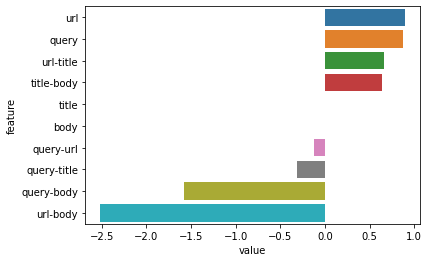

In [39]:
explain(15896) # "is holland the netherlands" positive
explain(15899) # "is holland the netherlands" negative